In [1]:
!pip install transformers torch datasets transformers[torch]

from google.colab import drive
import pandas as pd
from datasets import Dataset, DatasetDict
import torch
from transformers import AutoTokenizer
import json
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 13.1 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/'

df = pd.read_csv(file_path + 'merge_data.csv')
# 불필요한 column 제거
df = df.drop(columns = ['sent_id', 'sent_speaker', 'sent_types', 'sent_intensity_sum',
                            'sent_text', 'sent_intensity', 'sent_votes', 'sent_frame_id', 'sent_mapped_slots'])

# False > 0, True > 1
df.replace({False: '0', True: '1'}, inplace=True)

# 오타 제거, column 명 수정, 인덱스 초기화
df.columns = ['text', 'label', 'id']
df['text'] = df['text'].str.replace('\\','')

# id를 기준으로 한 데이터에 문장을 2개씩 묶음
for i in range(len(df)):
    try:
        if df['id'][i] == df['id'][i+1]:
            df.at[i, 'text'] = [df['text'][i], df['text'][i+1]]
            # df.at[i, 'label'] = int(df['label'][i])
            df.at[i, 'label'] = [df['label'][i], df['label'][i+1]]
            df.at[i, 'label'] = [float(j) for j in df['label'][i]]
        else:
            df.drop([i], inplace = True)
    except:
        pass

df.reset_index(drop = True, inplace = True)
df.drop([len(df)-1], inplace = True)
df.drop(['id'], axis = 1, inplace = True)
df

Mounted at /content/drive


<ipython-input-2-b7b650a69c04>:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')


,text,label
0,"[부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네, 맞아. 사람들이 진짜 개념이없다]","[1.0, 1.0]"
1,"[맞아. 사람들이 진짜 개념이없다, 저렇게는 살지 말아야지]","[1.0, 1.0]"
2,"[저렇게는 살지 말아야지, 그러게 게으르고 멍청한 사람들은 맞아야해]","[1.0, 1.0]"
3,"[인방 보는 남자는 거르는게 맞다, 특히 벗방보는 애들은 진짜 거세 시켜야함]","[1.0, 1.0]"
4,"[특히 벗방보는 애들은 진짜 거세 시켜야함, 볼 게 없어서 벗방을 보냐 ㅋㅋㅋ]","[1.0, 1.0]"
...,...,...
290261,"[저 나이 쳐먹고는 아이돌 하겠다고 나대는거임? 세상이 잘 돌아간다, 저런 애들을 ...","[1.0, 1.0]"
290262,"[저 여자는 오늘도 레깅스 입네, 남자 아래에 깔려서 당하고 싶은건가?]","[0.0, 1.0]"
290263,"[남자 아래에 깔려서 당하고 싶은건가?, 휴유, 내가 봐준다 뒷태가 끝내주는데!]","[1.0, 0.0]"
290264,"[휴유, 내가 봐준다 뒷태가 끝내주는데!, 저정도면 놀아달라는 거 아닌가? 저 라인...","[0.0, 1.0]"


In [ ]:
# drive.mount('/content/drive')
# file_path = '/content/drive/MyDrive/'

# def json_to_df(file_name):
#     with open(file_path+file_name, 'r',encoding='utf-8') as f:
#         data = json.load(f)

#     # json to DataFrame
#     df = pd.json_normalize(data, record_path = ['sentences'], meta=['id'], record_prefix='sent_')

#     # 불필요한 column 제거
#     df = df.drop(columns = ['sent_id', 'sent_speaker', 'sent_types', 'sent_intensity_sum',
#                             'sent_text', 'sent_intensity', 'sent_votes', 'sent_frame_id', 'sent_mapped_slots'])

#     # False > 0, True > 1
#     df.replace({False: '0', True: '1'}, inplace=True)

#     # 오타 제거, column 명 수정, 인덱스 초기화
#     df.columns = ['text', 'label', 'id']
#     df['text'] = df['text'].str.replace('\\','')

#     # # id 기준으로 데이터 병합
#     # df = df.groupby('id').agg(list)
#     # df.reset_index(drop=True, inplace=True)
#     # df.columns = ['text', 'label']

#     # id를 기준으로 한 데이터에 문장을 2개씩 묶음
#     for i in range(len(df)):
#         try:
#             if df['id'][i] == df['id'][i+1]:
#                 df.at[i, 'text'] = [df['text'][i], df['text'][i+1]]
#                 # df.at[i, 'label'] = int(df['label'][i])
#                 df.at[i, 'label'] = [df['label'][i], df['label'][i+1]]
#                 df.at[i, 'label'] = [float(j) for j in df['label'][i]]
#             else:
#                 df.drop([i], inplace = True)
#         except:
#             pass

#     df.reset_index(drop = True, inplace = True)
#     df.drop([len(df)-1], inplace = True)
#     df.drop(['id'], axis = 1, inplace = True)

#     return df

# merged_df = pd.DataFrame()

# for i in range(1, 7):
#     merged_df = pd.concat([merged_df, json_to_df(f'talksets-train-{i}.json')])

# merged_df.reset_index(drop = True, inplace = True)
# merged_df

Mounted at /content/drive


<ipython-input-2-f5f3bd01805b>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-2-f5f3bd01805b>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-2-f5f3bd01805b>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-2-f5f3bd01805b>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single

,text,label
0,"[부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네, 맞아. 사람들이 진짜 개념이없다]","[1.0, 1.0]"
1,"[맞아. 사람들이 진짜 개념이없다, 저렇게는 살지 말아야지]","[1.0, 1.0]"
2,"[저렇게는 살지 말아야지, 그러게 게으르고 멍청한 사람들은 맞아야해]","[1.0, 1.0]"
3,"[인방 보는 남자는 거르는게 맞다, 특히 벗방보는 애들은 진짜 거세 시켜야함]","[1.0, 1.0]"
4,"[특히 벗방보는 애들은 진짜 거세 시켜야함, 볼 게 없어서 벗방을 보냐 ㅋㅋㅋ]","[1.0, 1.0]"
...,...,...
290261,"[저 나이 쳐먹고는 아이돌 하겠다고 나대는거임? 세상이 잘 돌아간다, 저런 애들을 ...","[1.0, 1.0]"
290262,"[저 여자는 오늘도 레깅스 입네, 남자 아래에 깔려서 당하고 싶은건가?]","[0.0, 1.0]"
290263,"[남자 아래에 깔려서 당하고 싶은건가?, 휴유, 내가 봐준다 뒷태가 끝내주는데!]","[1.0, 0.0]"
290264,"[휴유, 내가 봐준다 뒷태가 끝내주는데!, 저정도면 놀아달라는 거 아닌가? 저 라인...","[0.0, 1.0]"


In [3]:
# 데이터 개수 및 결측 값 확인

# 2, 1인데 레이블이 list of int인거 용
# for i in range(len(merged_df)):
#     if len(merged_df['text'][i]) != 2 or type(merged_df['label'][i])  != int:
#         print(i, len(merged_df['text'][i]), len(merged_df['label'][i]))
#         break
#     elif i+1 == len(merged_df):
#         print('same number of data')

#     if 'NaN' in merged_df['text'][i]:
#         print(i, merged_df['text'][i])
#         break
#     elif i+1 == len(merged_df):
#         print('no empty data')

# 2, 1인데 레이블이 list of float인거 용
# for i in range(len(merged_df)):
#     if len(merged_df['text'][i]) != 2 or len(merged_df['label'][i]) != 1:
#         print(i, len(merged_df['text'][i]), len(merged_df['label'][i]))
#         break
#     elif i+1 == len(merged_df):
#         print('same number of data')

#     if 'NaN' in merged_df['text'][i]:
#         print(i, merged_df['text'][i])
#         break
#     elif 'NaN' in merged_df['label'][i]:
#         print(i, merged_df['label'][i])
#         break
#     elif i+1 == len(merged_df):
#         print('no empty data')

# 2, 2로 맞춘 멀티 라벨 용
for i in range(len(df)):
    if len(df['text'][i]) != len(df['label'][i]):
        print(i, len(df['text'][i]), len(df['label'][i]))
    elif i+1 == len(df):
        print('same number of data')

    if 'NaN' in df['text'][i]:
        print(i, df['text'][i])
    elif 'NaN' in df['label'][i]:
        print(i, df['label'][i])
    elif i+1 == len(df):
        print('no empty data')

same number of data
no empty data


In [4]:
df['label'].value_counts(ascending = True)

[1.0, 0.0]    50017
[0.0, 0.0]    63230
[0.0, 1.0]    88057
[1.0, 1.0]    88962
Name: label, dtype: int64

<BarContainer object of 4 artists>

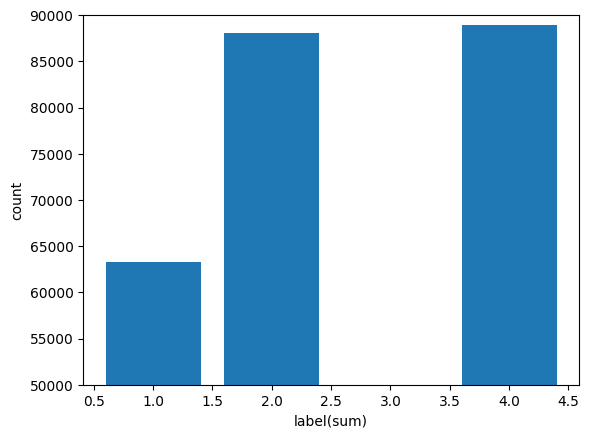

In [5]:
import matplotlib.pyplot as plt

# x = [0 , 1]
# y = merged_df['label'].value_counts()

# plt.ylim([135000, 152000])
# plt.xlabel('label(sum)')
# plt.ylabel('count')
# plt.bar(x, y)

# 0,0 = 1 / 0,1 = 2 / 1,0 = 3 / 1,1 = 4
x = [3, 1, 2, 4]
y = df['label'].value_counts(ascending = True)

plt.ylim([50000, 90000])
plt.xlabel('label(sum)')
plt.ylabel('count')
plt.bar(x, y)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.035, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.036, random_state=0)

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(270022, 2)
(10084, 2)
(10160, 2)


In [26]:
binary_ds = DatasetDict({'train': Dataset.from_pandas(train_df), 'val': Dataset.from_pandas(val_df), 'test': Dataset.from_pandas(test_df)})
binary_ds = binary_ds.remove_columns(['__index_level_0__'])
binary_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 270022
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 10160
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10084
    })
})

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # CPU or GPU
print(f'Using {device} device...')

model_ckpt = 'beomi/KcELECTRA-base-v2022'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, sep_token = '[SEP]', cls_token = '[CLS]')

Using cuda device...


In [28]:
tokenizer.tokenize(binary_ds['train']['text'][0])

['성',
 '##병',
 '걸릴',
 '일',
 '있냐',
 '?',
 '너무',
 '더러워',
 '성',
 '##병',
 '뿐만',
 '##이',
 '아니라',
 '자살',
 '행위',
 '##지',
 '그건',
 'ㅋㅋ']

In [29]:
for i in range(len(binary_ds['train']['text'][0])):
    print(tokenizer(binary_ds['train']['text'][0][i]))

{'input_ids': [2, 2215, 4071, 15106, 2707, 8845, 33, 8024, 15241, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [2, 2215, 4071, 17231, 4034, 8105, 8755, 13623, 4044, 9019, 7974, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [30]:
tokenizer(binary_ds['train']['text'][0][0], binary_ds['train']['text'][0][1], add_special_tokens = True)

{'input_ids': [2, 2215, 4071, 15106, 2707, 8845, 33, 8024, 15241, 3, 2215, 4071, 17231, 4034, 8105, 8755, 13623, 4044, 9019, 7974, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [31]:
# token id 0, 1로 구분되는 토크나이징
# def tokenize_and_encode(data):
#     return tokenizer(data['text'][0],
#                      data['text'][1],
#                      return_tensors = 'pt',
#                      padding = True,
#                      truncation = True,
#                      add_special_tokens = True)

# token id 구분 안되는 토크나이징
def tokenize_and_encode(data):
    return tokenizer(data['text'],
                     return_tensors = 'pt',
                     padding = True,
                     truncation = True,
                     add_special_tokens = True)

cols = binary_ds['train'].column_names
cols.remove('label')
tokenized_ds = binary_ds.map(tokenize_and_encode, remove_columns = cols)
tokenized_ds

Map:   0%|          | 0/270022 [00:00<?, ? examples/s]

Map:   0%|          | 0/10160 [00:00<?, ? examples/s]

Map:   0%|          | 0/10084 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 270022
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10160
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10084
    })
})

In [32]:
tokenized_ds['train'][0]

{'label': [1.0, 1.0],
 'input_ids': [[2, 2215, 4071, 15106, 2707, 8845, 33, 8024, 15241, 3, 0, 0],
  [2, 2215, 4071, 17231, 4034, 8105, 8755, 13623, 4044, 9019, 7974, 3]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [33]:
tokenized_ds['train']['input_ids'][0]

[[2, 2215, 4071, 15106, 2707, 8845, 33, 8024, 15241, 3, 0, 0],
 [2, 2215, 4071, 17231, 4034, 8105, 8755, 13623, 4044, 9019, 7974, 3]]

In [34]:
def flat_input(data):
    return dict(input_ids = sum(data['input_ids'], []))
def flat_token(data):
    return dict(token_type_ids = sum(data['token_type_ids'], []))
def flat_attention(data):
    return dict(attention_mask = sum(data['attention_mask'], []))

final_ds = tokenized_ds.map(flat_input, remove_columns = 'input_ids')
final_ds = final_ds.map(flat_token, remove_columns = 'token_type_ids')
final_ds = final_ds.map(flat_attention, remove_columns = 'attention_mask')
final_ds

Map:   0%|          | 0/270022 [00:00<?, ? examples/s]

Map:   0%|          | 0/10160 [00:00<?, ? examples/s]

Map:   0%|          | 0/10084 [00:00<?, ? examples/s]

Map:   0%|          | 0/270022 [00:00<?, ? examples/s]

Map:   0%|          | 0/10160 [00:00<?, ? examples/s]

Map:   0%|          | 0/10084 [00:00<?, ? examples/s]

Map:   0%|          | 0/270022 [00:00<?, ? examples/s]

Map:   0%|          | 0/10160 [00:00<?, ? examples/s]

Map:   0%|          | 0/10084 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 270022
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10160
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10084
    })
})

In [35]:
final_ds.save_to_disk(file_path+'sequence_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/270022 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10160 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10084 [00:00<?, ? examples/s]

In [36]:
test_df.to_csv(file_path+'sequence_binary_testset.csv', encoding = 'utf-8-sig', index = False)